In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
import pickle
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import *
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

from jax.scipy.special import gammaln

import mrcfile

plt.rcParams["figure.figsize"]=6,6

In [3]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


In [1018]:
K = 2
N = 1000
sigma = 0.01

alpha = 0.5 * jnp.ones(K,)

In [1021]:
key, subkey = random.split(key)
pi = random.dirichlet(subkey, alpha)
print(pi)
print(jnp.sum(pi))

[0.99823618 0.00176382]
1.0


In [1022]:
#pi = jnp.array([0.68387323, 0.31612677])

In [1023]:
key, subkey = random.split(key)
z = random.categorical(subkey, jnp.log(pi), shape = (N,))
print(jnp.sum(z==0)/N)
print(jnp.sum(z==1)/N)

0.998
0.002


In [1024]:
z

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1046]:
key, subkey = random.split(key)
x = random.normal(subkey, shape = (K,))
print(x)
#print(y.shape)

[ 2.07949417 -0.95449543]


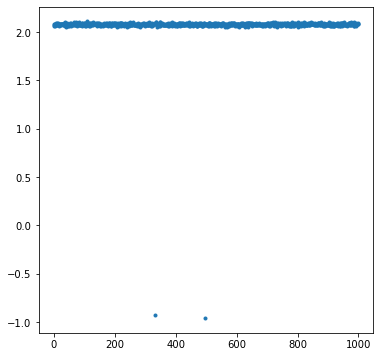

In [1048]:
key, subkey = random.split(key)
y = x[z] + sigma * random.normal(subkey, shape = (N,))
plt.plot(y, '.')

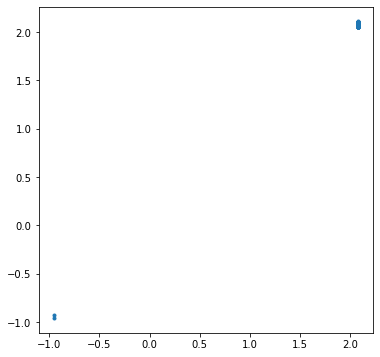

In [1049]:
plt.plot(x[z], y, '.')

In [1050]:
def calc_nik_ki(z,k,i): 
    z = z.at[i].set(jnp.inf)    
    return jnp.sum(z == k)

calc_nik_i = lambda z, i : jax.vmap(calc_nik_ki, in_axes = (None, 0, None))(z, jnp.arange(K), i)
calc_nik = lambda z : jax.vmap(calc_nik_i, in_axes = (None, 0))(z, jnp.arange(N))
calc_nik_jit = jax.jit(calc_nik)

calc_nk_k = lambda z, k : jnp.sum(z == k)
calc_nk = lambda z : jax.vmap(calc_nk_k, in_axes = (None, 0))(z, jnp.arange(K))
calc_nk_jit = jax.jit(calc_nk)

In [1051]:
calc_nik_jit(z).shape

(1000, 2)

In [1052]:
print(calc_nik_ki(z, 0, 13))
print(calc_nik_ki(z, 1, 13))
print(calc_nik_ki(z, 2, 13))

997
2
0


In [1053]:
calc_nik_jit(z).shape

(1000, 2)

In [1054]:
pi

DeviceArray([0.99823618, 0.00176382], dtype=float64)

In [1113]:
def logPi(x, z, y, sigma, alpha):
    n_ik = calc_nik_jit(z)
    n_k = calc_nk_jit(z)
    
    log_arg = jnp.zeros(y.shape)
    logPZalpha = -gammaln(jnp.sum(n_k) + jnp.sum(alpha))

    Nk = jnp.sum(n_k)
    Ak = jnp.sum(alpha)
    
    # TODO: vectorize
    term_mat = []
    for k in jnp.arange(K):
        logarg_k = jnp.exp(-(y - x[k])**2/sigma) * (n_ik[:, k] + alpha[k])/(Nk+Ak-1)
        log_arg += logarg_k
        term_mat.append(logarg_k)
        #log_arg += jnp.exp(jnp.exp(-(y - x[k])**2/sigma))*pi[k]
        
        logPZalpha += gammaln(n_k[k] + alpha[k])
    
    #print(logPZalpha)
    print("term A ", jnp.sum(jnp.log(log_arg)) )
    #print("term B ", - jnp.sum(x**2))
    return jnp.sum(jnp.log(log_arg)) - jnp.sum(x**2) + logPZalpha #, jnp.array(term_mat).transpose()




In [1114]:
key, subkey = random.split(key)
#z0 = random.randint(subkey, z.shape, 0, K)
z0 = jnp.ones(z.shape)
z0 = z

n_ik_z = calc_nik_jit(z0)
n_k = calc_nk_jit(z0)
Nk = jnp.sum(n_k)
Ak = jnp.sum(alpha)

In [1115]:
probs_d = []
probs_dn = []
for k in jnp.arange(K):
    probs_d.append((n_ik_z[:, k] + alpha[k])/(Nk+Ak-1))
    probs_dn.append((n_ik_z[:, k])/(Nk-1))

probs_d = jnp.array(probs_d).transpose()   
probs_dn = jnp.array(probs_dn).transpose()   


In [1116]:
probs_d

DeviceArray([[0.9975, 0.0025],
             [0.9975, 0.0025],
             [0.9975, 0.0025],
             ...,
             [0.9975, 0.0025],
             [0.9975, 0.0025],
             [0.9975, 0.0025]], dtype=float64)

In [1117]:
jnp.sum(probs_d, axis=1)

DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
             1., 1., 1., 1., 1., 1., 1., 1., 1., 1.

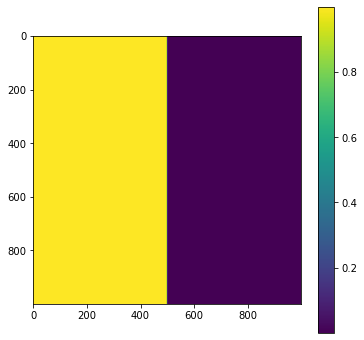

In [1118]:
plt.imshow(jnp.repeat(probs_d, int(N/K), axis=1)); plt.colorbar()

In [1119]:
n_ik_z.shape

(1000, 2)

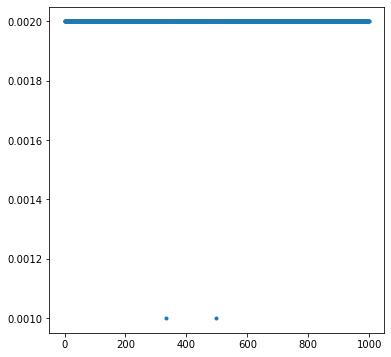

In [1120]:
plt.plot(n_ik_z[:,4]/N,'.')

In [1121]:
logPi(x, z, y, sigma, alpha)

term A  -25.507599790741377


DeviceArray(-47.72578638, dtype=float64)

In [1122]:
pi

DeviceArray([0.99823618, 0.00176382], dtype=float64)

In [1123]:
z

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1124]:
key, subkey = random.split(key)
z0 = random.randint(subkey, z.shape, 0, K)
#z0 = jnp.ones(z.shape)
z0 = z
_, terms_01 = logPi(jnp.array([x[0], x[1]]), z, y, sigma, alpha)
_, terms_11 = logPi(jnp.array([x[1], x[1]]), z, y, sigma, alpha)
_, terms_00 = logPi(jnp.array([x[0], x[0]]), z, y, sigma, alpha)
_, terms_10 = logPi(jnp.array([x[1], x[0]]), z, y, sigma, alpha)

term A  -25.507599790741377


TypeError: iteration over a 0-d array

In [1125]:
logPi(jnp.array([x[0], x[1]]), z, y, sigma, alpha)
logPi(jnp.array([x[1], x[1]]), z, y, sigma, alpha)
logPi(jnp.array([x[0], x[0]]), z, y, sigma, alpha)
logPi(jnp.array([x[1], x[0]]), z, y, sigma, alpha)

term A  -25.507599790741377
term A  -inf
term A  -inf
term A  -5989.48951575733


DeviceArray(-6011.70770235, dtype=float64)

In [1126]:
z

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1127]:
y

DeviceArray([ 2.08751934,  2.07232652,  2.06751799,  2.0841371 ,
              2.08228018,  2.05938779,  2.0885866 ,  2.07296037,
              2.07610666,  2.09053589,  2.06813338,  2.07603177,
              2.08097911,  2.08900355,  2.08597682,  2.08621082,
              2.06427495,  2.08791464,  2.07697129,  2.08216691,
              2.08463385,  2.07234433,  2.07267672,  2.07101302,
              2.08326784,  2.08010931,  2.08459885,  2.0799445 ,
              2.07969592,  2.07530482,  2.08386334,  2.0821788 ,
              2.08400567,  2.07320807,  2.08972056,  2.07457198,
              2.06181172,  2.07372614,  2.10689317,  2.06960481,
              2.07550045,  2.05640995,  2.06376759,  2.08644094,
              2.09431318,  2.07774413,  2.07708125,  2.07558118,
              2.06594323,  2.07167369,  2.06461109,  2.07105493,
              2.06794959,  2.07205419,  2.0961167 ,  2.06505523,
              2.07795372,  2.0681785 ,  2.09744521,  2.08137186,
              2.08377294,

In [1128]:
x

DeviceArray([ 2.07949417, -0.95449543], dtype=float64)

In [1129]:
z

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1130]:
jnp.exp(-(x[0]-y[0])**2/sigma)

DeviceArray(0.99358035, dtype=float64)

In [1131]:
print(terms_01)
print(terms_11)
print(terms_00)
print(terms_10)

[[8.33255334e-001 1.22928057e-135]
 [8.04978264e-001 5.86964955e-133]
 [7.98368228e-001 5.77070675e-139]]
[[6.14640284e-135 1.22928057e-135]
 [2.93482477e-132 5.86964955e-133]
 [2.88535338e-138 5.77070675e-139]]
[[0.83325533 0.16665107]
 [0.80497826 0.16099565]
 [0.79836823 0.15967365]]
[[6.14640284e-135 1.66651067e-001]
 [2.93482477e-132 1.60995653e-001]
 [2.88535338e-138 1.59673646e-001]]


In [1132]:
z

DeviceArray([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [1133]:
xk = jnp.array([x[1],x[0]])
print(jnp.exp(-(y[0]-xk[0])**2/sigma))
print(jnp.exp(-(y[0]-xk[1])**2/sigma))

0.0
0.9935803507798806


In [1134]:
print(x)
print(y[0])

[ 2.07949417 -0.95449543]
2.087519342458877


In [1135]:
print(terms_10)

[[6.14640284e-135 1.66651067e-001]
 [2.93482477e-132 1.60995653e-001]
 [2.88535338e-138 1.59673646e-001]]


In [1136]:
jnp.sum(jnp.log(jnp.sum(terms_01, axis=1)))

DeviceArray(-0.62454051, dtype=float64)

In [1137]:
z_correct = z

In [1138]:
@jax.jit
def proposal_x(key, x0, logPiX0, B, z, y, sigma, alpha):
    #print("z", z[:10])
    #print("z_correct", z_correct[:10])
    #print(jnp.sum(jnp.abs(z-z_correct)))
    
    x1 = random.uniform(key, x0.shape) * 2*B-B
    
    logPiX0 = logPi(x0, z, y, sigma, alpha)
    logPiX1 = logPi(x1, z, y, sigma, alpha)
    
    r = jnp.exp((logPiX1 - logPiX0))
    
    return x1, r, logPiX1, logPiX0

@jax.jit
def proposal_x0(key, x00, logPiX0, B, x1, z, y, sigma, alpha):
    x01 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x00, x1]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x01, x1]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x01, r, logPiX1, logPiX0    

@jax.jit
def proposal_x1(key, x10, logPiX0, B, x0, z, y, sigma, alpha):
    x11 = random.uniform(key) * 2*B-B
    
    logPiX0 = logPi(jnp.array([x0, x10]), z, y, sigma, alpha)
    logPiX1 = logPi(jnp.array([x0, x11]), z, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return x11, r, logPiX1, logPiX0    

@jax.jit
def proposal_z(key, z0, logPiX0, x, y, sigma, alpha, K):
    z1 = random.randint(key, z0.shape, 0, K) 
    
    logPiX0 = logPi(x, z0, y, sigma, alpha)
    logPiX1 = logPi(x, z1, y, sigma, alpha)
    
    r = jnp.exp(logPiX1 - logPiX0)
    
    return z1, r, logPiX1, logPiX0
     

### First, sample x

In [1139]:
print(pi)
print(x)

[0.99823618 0.00176382]
[ 2.07949417 -0.95449543]


term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
  MCMC sample 1000, loss = 64.32380027504153, a = 0.0
  MCMC sample 2000, loss = 55.583971778523626, a = 0.0
  MCMC sample 3000, loss = 55.583971778523626, a = 0.0
  MCMC sample 4000, loss = 55.583971778523626, a = 0.0
  MCMC sample 5000, loss = 55.583971778523626, a = 0.0
  MCMC sample 6000, loss = 55.583971778523626, a = 9.824144703077955e-158
  MCMC sample 7000, loss = 55.583971778523626, a = 0.0
  MCMC sample 8000, loss = 55.583971778523626, a = 0.0
  MCMC sample 9000, loss = 55.583971778523626, a = 0.0
[-0.26446605 -0.37922105]
[ 2.08799759 -1.0099152 ]
[ 2.07949417 -0.95449543]


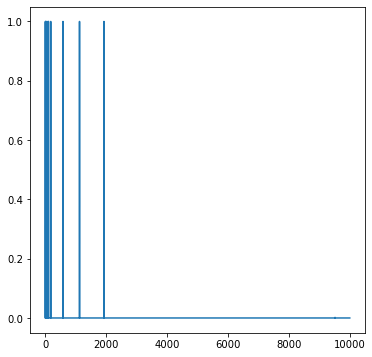

In [1140]:
N_samples_x = 10000
x0 = jnp.array(np.random.randn(K))
B = 3

params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
  MCMC sample 1000, loss = 47.72383974102501, a = 0.0
  MCMC sample 2000, loss = 47.96973883292658, a = 0.0
  MCMC sample 3000, loss = 47.96973883292658, a = 0.0
  MCMC sample 4000, loss = 47.96973883292658, a = 0.0
  MCMC sample 5000, loss = 47.96973883292658, a = 0.0
  MCMC sample 6000, loss = 47.883079252765754, a = 0.0
  MCMC sample 7000, loss = 47.72261428212696, a = 0.0
  MCMC sample 8000, loss = 47.734454553962664, a = 0.0
  MCMC sample 9000, loss = 47.76124893217009, a = 0.0
  MCMC sample 10000, loss = 47.746415348801975, a = 0.0
0.9299768646163661
2.080215980661854
[ 2.07949417 -0.95449543]


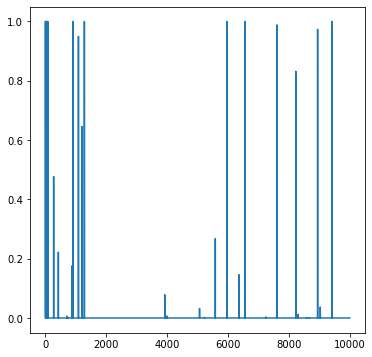

In [1141]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x1" : x[1]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x0, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)

print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)

term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
term A  Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=0/1)>
  MCMC sample 1000, loss = 47.99036472286322, a = 0.0
  MCMC sample 2000, loss = 48.24969050396501, a = 5.371516420724833e-25
  MCMC sample 3000, loss = 47.7666248644847, a = 1.060254351620618e-13
  MCMC sample 4000, loss = 48.72929763409248, a = 0.0
  MCMC sample 5000, loss = 47.997064534009986, a = 0.0
  MCMC sample 6000, loss = 47.67201838465445, a = 0.0
  MCMC sample 7000, loss = 48.065608425893416, a = 0.00938459170828039
  MCMC sample 8000, loss = 48.01604127583954, a = 2.4786675621677225e-65
  MCMC sample 9000, loss = 48.07392111956928, a = 0.0
  MCMC sample 10000, loss = 47.77311610142996, a = 0.0
0.5319791159458466
-0.9133996056778044
[ 2.07949417 -0.95449543]


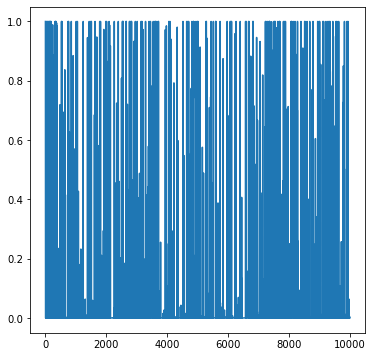

In [1142]:
N_samples_x = 10001
#x0 = jnp.array(np.random.randn(K))
x0 = jnp.array(np.random.rand())
B = 3

#params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha}
params_x = {"B" : B, "z" : z, "y" : y, "sigma" : sigma, "alpha" : alpha, "x0" : x[0]}

key, subkey = random.split(key)
x_mean, x_r, x_sample = mcmc(subkey, proposal_x1, x0, N_samples_x, params_x, 1, 1)

plt.plot(x_r)
print(x0)
print(x_sample[N_samples_x-2])
#print(x_mean)
print(x)


In [1143]:
logPi(x, z, y, sigma, alpha)


term A  -25.507599790741377


DeviceArray(-47.72578638, dtype=float64)

In [1144]:
logPi(jnp.array([x[0],x[1]]), z, y, sigma, alpha)

term A  -25.507599790741377


DeviceArray(-47.72578638, dtype=float64)

In [1145]:
logPi(jnp.array([x[1],x[1]]), z, y, sigma, alpha)

term A  -inf


DeviceArray(-inf, dtype=float64)

In [1146]:
x

DeviceArray([ 2.07949417, -0.95449543], dtype=float64)

In [1147]:
myf = lambda x0, x1 : logPi(jnp.array([x0, x1]), z0, y, sigma, alpha)
xx = jnp.linspace(-3,3,1000)    
yy = jnp.linspace(-3,3,1000)

In [1148]:
myf_x = jax.jit(lambda x : jax.vmap(myf, in_axes = (None, 0))(x, yy))
myf_xy = jax.vmap(myf_x)(xx)

term A  Traced<ShapedArray(float64[])>with<BatchTrace(level=2/1)> with
  val = Traced<ShapedArray(float64[1000])>with<BatchTrace(level=1/1)> with
    val = Traced<ShapedArray(float64[1000,1000])>with<DynamicJaxprTrace(level=0/1)>
    batch_dim = 0
  batch_dim = 0


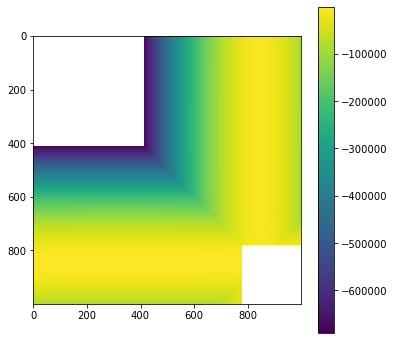

In [1149]:
plt.imshow((myf_xy)); plt.colorbar()

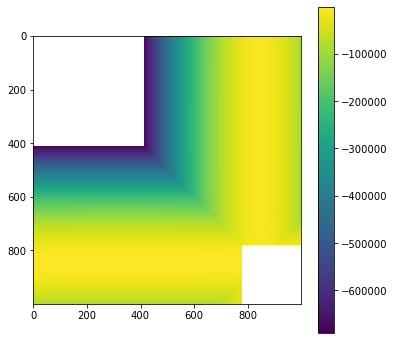

In [1150]:
plt.imshow((myf_xy)); plt.colorbar()

In [1151]:
jnp.log(8) + jnp.log(4)

DeviceArray(3.4657359, dtype=float64)

In [1152]:
#plt.imshow(jnp.abs(myf_xy0-myf_xy2)); plt.colorbar()

In [1153]:
print("01", myf(x[0], x[1]))
print("00", myf(x[0], x[0]))
print("11", myf(x[1], x[1]))
print("10", myf(x[1], x[0]))

term A  -25.507599790741377
01 -47.725786381035185
term A  -inf
00 -inf
term A  -inf
11 -inf
term A  -5989.48951575733
10 -6011.707702347623


In [1154]:
myf(x[0],x[1])

term A  -25.507599790741377


DeviceArray(-47.72578638, dtype=float64)

In [1155]:
jnp.max(myf_xy)

DeviceArray(-47.84696515, dtype=float64)

### Now sample z

In [1156]:
z.shape

(1000,)

In [ ]:
N_samples_z = 10001
z0 = jnp.array(np.random.randint(0, K, (N,)))
B = 3

params_z = {"x" : x, "y" : y, "sigma" : sigma, "alpha" : alpha, "K" : K}

key, subkey = random.split(key)
z_mean, z_r, z_samples = mcmc(subkey, proposal_z, z0, N_samples_z, params_z, 1, 1)
z_rec = z_samples[N_samples_z-2]

plt.plot(z_r)
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)


  MCMC sample 1000, loss = 1304.247962808513, a = 6.073822312412701e-45


In [ ]:
print(jnp.sum(jnp.abs(z0-z))/N)
print(jnp.sum(jnp.abs(z_rec-z))/N)

In [ ]:
plt.plot(jnp.abs(z0-z), '.')


In [ ]:
plt.plot(jnp.abs(z_rec-z), '.')

In [ ]:
z

In [ ]:
z_rec

In [ ]:
pi

In [ ]:
x